In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras import models, layers
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
import os
import logging
from sklearn.model_selection import KFold

In [2]:
logging.basicConfig(filename='logs.txt',
                   filemode='a',
                   format='%(asctime)s %(levelname)s-%(message)s',
                   datefmt='%Y-%m-%d %H:%M:%S',
                   force=True,
                    level=logging.INFO
                   )

In [3]:
from python_project import connect_database

In [4]:
try_again = True
while try_again:
    try:
        session = connect_database.connect()
        try_again = False
    except:
        logging.error("Connection attempt failed! Trying again")
        try_again = True

4.0.0.6816


## Cleaning Data Function

In [5]:
def clean_data(dataframe):
    try:
        dataframe['text'] = dataframe['text'].apply(lambda x: x.replace('-', ' '))
    except: 
        logging.error("Dataframe has 'text' column missing.")
    return dataframe

## Getting Data From Database

In [10]:
from python_project import database_interaction as db

In [11]:
df = db.get_dataframe()

4.0.0.6816


In [12]:
# categories in the dataset
df['category'].unique()

array(['entertainment', 'sport', 'tech', 'politics', 'business'],
      dtype=object)

In [13]:
df.head(5)

,article_id,news,category
0,1584,alicia keys to open us super bowl r&b star ali...,entertainment
1,1863,johnson uncertain about euro bid jade johnson ...,sport
2,1765,nintendo ds aims to touch gamers the mobile ga...,tech
3,2062,turkey deal to help world peace a deal bring...,politics
4,1199,sales fail to boost high street the january ...,business


## Model

In [14]:
# only considering the most common 1000 words
# TODO: tune parameter if required

tokenizer = Tokenizer(num_words=2000)

# builds the word index
tokenizer.fit_on_texts(list(df['news']))

# the fitted tokenizer now converts the text to integer sequences
train_dataset = tokenizer.texts_to_sequences(list(df['news']))

logging.info("The dataset is retrieved from the database and is preprocessed")
# train_dataset = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='pre')

In [15]:
def vectorize_sequences(sequences, dimension=2000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results


In [16]:
x_train = vectorize_sequences(train_dataset, dimension=2000)

## Preparing Output Labels

In [17]:
train_labels = list(df['category'])

In [18]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

In [19]:
# Encode labels in column 'species'.
df['category']= label_encoder.fit_transform(df['category'])

In [20]:
label_encoder.classes_

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [21]:
train_labels = df['category']

In [22]:
train_labels.value_counts()

3    346
0    336
2    274
1    273
4    261
Name: category, dtype: int64

In [23]:
y_train = to_categorical(train_labels)

In [24]:
y_train[0]

array([0., 1., 0., 0., 0.], dtype=float32)

## Model

In [25]:
from sklearn import metrics

In [26]:
# cross-validate 
kf = KFold(n_splits=4, shuffle=True, random_state=42)

In [27]:
fold = 0
oos_y = list()
oos_pred = list()
all_scores = list()

for train, test in kf.split(x_train):
    
    fold += 1
    print(f"Fold Number: {fold}")
#     print(train.shape)
#     print(test)
    x_train_fold = x_train[train]
    y_train_fold = y_train[train]
    x_test_fold = x_train[test]
    y_test_fold = y_train[test]
    
    model = models.Sequential()
    # , kernel_regularizer=regularizers.l2(0.001)
    model.add(layers.Dense(5, activation='relu', input_shape=(2000,)))
#     model.add(layers.Dense(6, activation='relu'))
#     model.add(layers.Dense(12, activation='relu'))
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(6, activation='relu'))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['acc'])
    
    history = model.fit(
    x_train_fold, 
    y_train_fold,
    epochs=20,
    batch_size=1,
    verbose=0,
    validation_data=(x_test_fold, y_test_fold)
    )
    
    pred = model.predict(x_test_fold)
    pred_comp = np.argmax(pred, axis=1)
    
#     oos_y.append(y_test_fold)
#     oos_pred.append(pred)
    
    y_test_comp = np.argmax(y_test_fold, axis=1)
    
    oos_y.append(y_test_comp)
    oos_pred.append(pred_comp)
    
    # Measuring this fold's RMSE
    # cce = tf.keras.losses.CategoricalCrossentropy()
    # print(f"Loss for Fold {fold} : {cce(y_test_fold, pred).numpy()}")
    score = metrics.accuracy_score(y_test_comp, pred_comp)
    print(f"Loss for Fold {fold} : {score}")
    all_scores.append(score)
    
# Build the oos prediction list and calculate the error
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

# cce = tf.keras.losses.CategoricalCrossentropy()
# print(f"Total Loss Computed : {cce(oos_y, oos_pred).numpy()}")
score = np.array(all_scores).mean()
print(f"\n\nTotal loss computed : {score}")

    

Fold Number: 1
Loss for Fold 1 : 0.9651474530831099
Fold Number: 2
Loss for Fold 2 : 0.9731903485254692
Fold Number: 3
Loss for Fold 3 : 0.956989247311828
Fold Number: 4
Loss for Fold 4 : 0.9650537634408602


Total loss computed : 0.9650952030903168


In [28]:
np.array([1, 2, 3]).mean()

2.0

In [29]:
train_labels

0       1
1       3
2       4
3       2
4       0
       ..
1485    4
1486    2
1487    0
1488    3
1489    3
Name: category, Length: 1490, dtype: int32

In [30]:
from keras import regularizers

In [31]:
model = models.Sequential()
# , kernel_regularizer=regularizers.l2(0.001)
model.add(layers.Dense(4, activation='relu', input_shape=(2000,)))
# model.add(layers.Dropout(0.4))
model.add(layers.Dense(6, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

In [32]:
# model =models.Sequential([
#     layers.Embedding()
# ])

In [33]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt,
loss='categorical_crossentropy',
metrics=['acc'])

In [34]:
x_val = x_train[1200:]
partial_x_train = x_train[:1200]

y_val = y_train[1200:]
partial_y_train = y_train[:1200]

In [35]:
history = model.fit(
    x_train, 
    y_train,
    epochs=20,
    batch_size=1,
    validation_data=(x_val, y_val)
)

Epoch 1/20
1490/1490 [==============================] - 5s 3ms/step - loss: 1.3918 - acc: 0.3752 - val_loss: 0.9447 - val_acc: 0.7172
Epoch 2/20
1490/1490 [==============================] - 5s 3ms/step - loss: 0.8971 - acc: 0.6302 - val_loss: 0.5467 - val_acc: 0.8034
Epoch 3/20
1490/1490 [==============================] - 5s 4ms/step - loss: 0.6730 - acc: 0.7081 - val_loss: 0.4270 - val_acc: 0.8034
Epoch 4/20
1490/1490 [==============================] - 5s 4ms/step - loss: 0.6064 - acc: 0.7309 - val_loss: 0.3802 - val_acc: 0.8552
Epoch 5/20
1490/1490 [==============================] - 5s 3ms/step - loss: 0.5366 - acc: 0.7846 - val_loss: 0.2366 - val_acc: 0.9552
Epoch 6/20
1490/1490 [==============================] - 5s 4ms/step - loss: 0.4658 - acc: 0.8302 - val_loss: 0.2417 - val_acc: 0.9655
Epoch 7/20
1490/1490 [==============================] - 5s 3ms/step - loss: 0.4303 - acc: 0.8624 - val_loss: 0.1695 - val_acc: 0.9690
Epoch 8/20
1490/1490 [==============================] - 5s 3ms

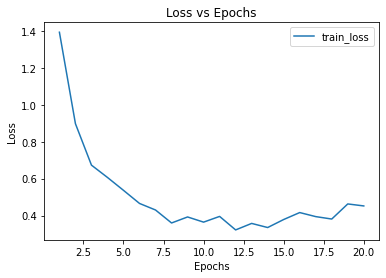

In [36]:
loss = history.history['loss']
val_loss = history.history['loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='train_loss')
# plt.plot(epochs, val_loss, label='val_loss')

plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

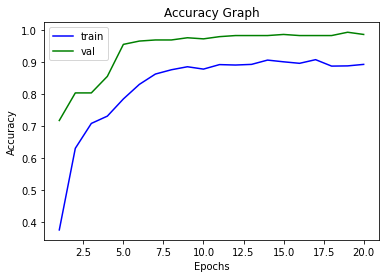

In [37]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, color='blue', label='train')
plt.plot(epochs, val_acc, color='green', label='val')

plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

## Test Data

In [29]:
test = pd.read_csv('test.csv')

In [30]:
test.head()

,article_id,text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [31]:
article_id_test = test['article_id']

In [32]:
test_df = clean_data(test)

In [33]:
# only considering the most common 1000 words
# TODO: tune parameter if required

tokenizer = Tokenizer(num_words=2000)

# builds the word index
tokenizer.fit_on_texts(list(test_df['text']))

# the fitted tokenizer now converts the text to integer sequences
test_dataset = tokenizer.texts_to_sequences(list(test_df['text']))

In [34]:
x_test = vectorize_sequences(test_dataset)

In [35]:
predictions = model.predict(x_test)

In [36]:
len(predictions)

735

In [37]:
prediction_copy = predictions.copy()

In [38]:
prediction_copy = np.argmax(prediction_copy, axis=1)

In [39]:
# cat_map = {0: 'business', 1: 'entertainment', 2:'politics', 3:'sport', 4:'tech'}

In [40]:
category_number = [np.argmax(x) for x in predictions]

In [41]:
names = label_encoder.inverse_transform(category_number)

In [46]:
label_encoder.classes_

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [44]:
names

array(['business', 'business', 'politics', 'business', 'business',
       'politics', 'business', 'politics', 'business', 'business',
       'sport', 'entertainment', 'politics', 'business', 'politics',
       'politics', 'politics', 'entertainment', 'politics',
       'entertainment', 'business', 'business', 'business', 'business',
       'business', 'politics', 'business', 'politics', 'tech',
       'entertainment', 'business', 'business', 'business',
       'entertainment', 'tech', 'business', 'business', 'business',
       'business', 'politics', 'business', 'business', 'tech', 'business',
       'entertainment', 'entertainment', 'entertainment', 'politics',
       'business', 'entertainment', 'entertainment', 'business',
       'business', 'tech', 'politics', 'business', 'business', 'business',
       'business', 'business', 'business', 'entertainment', 'business',
       'business', 'business', 'business', 'entertainment',
       'entertainment', 'entertainment', 'entertainment',

In [42]:
preds = pd.DataFrame({'ArticleId': article_id_test, 'Category': names})

In [43]:
preds.Category.value_counts()

business         413
entertainment    186
politics          96
tech              29
sport             11
Name: Category, dtype: int64

In [167]:
preds.head()

,ArticleId,Category
0,1018,business
1,1319,politics
2,1138,tech
3,459,business
4,1020,politics


In [168]:
preds.to_csv('submission_news.csv', index=False)

## Saving The Model

In [ ]:
model_version = "0001"
model_name = "news_classification_model"
model_path = os.path.join(model_name, model_version)
model_path

In [ ]:
tf.saved_model.save(model, model_path)

# LAB EXPERIMENTS!! Do Not Enter

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
preds['Category'].value_counts()

In [ ]:
seq_lb = [[1, 2, 3],
         [2, 3],
         [1, 3]]

In [ ]:
dimension=5
results = np.zeros((len(seq_lb), dimension))
results

In [ ]:
for i, seq in enumerate(seq_lb):
    results[i, seq] = 1
    print(results[i, seq] )
    print("=")

In [ ]:
results

In [ ]:
from keras.datasets import imdb
(train_data, train_label), (test_data, test_label) = imdb.load_data(num_words=10000)

In [ ]:
x_train = vectorize_sequences(train_data, 10000)
x_test = vectorize_sequences(test_data, 10000)
y_train = np.asarray(train_label).astype('float32')
y_test = np.asarray(test_label).astype('float32')

In [ ]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt,
loss='categorical_crossentropy',
metrics=['acc'])

In [ ]:
x_val = x_train[10000:]
partial_x_train = x_train[:10000]

y_val = train_label[10000:]
partial_y_train = train_label[:10000]

In [ ]:
history = model.fit(
    x_train, 
    y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val)
)